## Delta-Hedging for Arithmetic and Asian Call Options ##

In [5]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

#Import helper functions for MC/RQMC methods, GBM path generation, and asian option payoffs:
import asian, paths, lds
from scipy.stats import norm

### **Setup**

In this notebook, we simulate **Delta-hedging** strategied for Asian call options.

We consider the case where:

- Spot price: $S_0$ at initial time $t_0 = 0$
- Monitoring times: $\{ t_1, \ldots, t_d = T \}$, assumed to be **equidistant**, i.e. $t_i = i \, \frac{T}{d}$
- Strike price: $K$
- Asset dynamics: $S_t$ following a **geometric Brownian motion (GBM)** with interest rate $r$ and volatility $\sigma$


In [6]:
# Paramters
S0, K, r, sigma, T = 100.0, 100.0, 0.02, 0.20, 10.0
d = 20                     

# RQMC
n_paths_est = 2**14        # paths per replicate (pricing & Δ0)
R_repl_est  = 16           # independent digital shifts (replicates)
h_rel       = 5e-4         # CFD delta for Δ0 (arithmetic only)
BASE_SEED   = 123

# Outer evaluation (hedging) paths
n_paths_eval = 2**14

# Precompute bridge stuff once
precomp = paths.precompute_all(T, d)

## Delta-Hedging strategy ##

We simulate and compare the **profits** (from the seller's perspective) of:

- an **unhedged** strategy, and  
- a **$\Delta$-hedged** strategy,  

for both **geometric** and **arithmetic** Asian options:

$$
\begin{aligned}
P_{\text{Unhedged}} &= e^{-rT} \left( V_{t_0} - \max\{A_T - K, 0\} \right), \\
P_{\text{Hedged}} &= e^{-rT} \left( V_{t_0} - \max\{A_T - K, 0\} \right)
+ \sum_{i=1}^d \big( e^{-r t_i} S_{t_i} - e^{-r t_{i-1}} S_{t_{i-1}} \big) \Delta_{t_{i-1}}.
\end{aligned}
$$

---

### **Parameter Definitions**

- $V_{t_0}$ is the **fair (not discounted)** price of the call option.  
  - For the **geometric** case: evaluated in **closed form**.  
  - For the **arithmetic** case: estimated using **RQMC + Brownian Bridge + antithetic and geometric control variate** techniques.

---

### **Conditional Expectation and Intermediate Pricing**

Conditioning on the realized portion of the GBM path before time $t_i$:

$$
V_{t_i} = \mathbb{E}\!\left[ \max\{ G_T - K, 0\} \,\middle|\, S_{t_0}, \ldots, S_{t_{i-1}} \right]
= \widetilde{S}_{t_i} e^{\mu_i \tau} \Phi(d_{1,i}) - K \Phi(d_{2,i}),
$$

where, replacing $\tau = T - t$, $j = d - i$, and $\widetilde{S}_t = G_{t_i}^{i/d} S_{t_i}^{j/d}$, we have:

$$
\begin{aligned}
\sigma_i^2 &= \left( \frac{j}{d} \right)
\frac{\sigma^2 (j + 1)(2j + 1)}{6 j^2}, \qquad
\mu_i = \left( \frac{j}{d} \right)
\left[ \left( r - \tfrac{1}{2}\sigma^2 \right)\frac{j + 1}{2j} + \tfrac{1}{2}\sigma_i^2 \right], \\[6pt]
d_{1,i} &= \frac{\ln(\widetilde{S}_t / K) + (\mu_i + \tfrac{1}{2}\sigma_i^2)\tau}{\sigma_i \sqrt{\tau}}, \qquad
d_{2,i} = d_{1,i} - \sigma_i \sqrt{\tau}.
\end{aligned}
$$

---

### **Delta Computation**

Differentiating, we obtain the **delta** in the **geometric case**:

$$
\Delta_{t_i} =
\frac{j}{d} \left( \frac{\widetilde{S}_{t_i}}{S_{t_i}} \right)
e^{\mu_i \tau + \frac{1}{2}\sigma_i^2 \tau}
\Phi(d_{1,i}).
$$

For the **arithmetic case**, geometric deltas are used as **proxies** (for $t_i > t_0$) to avoid simulating at each step, and

$$
\Delta_{t_0} =
\frac{V_{t_0}(S_{t_0} + h) - V_{t_0}(S_{t_0} - h)}{2h}
$$

is obtained via the **central finite difference** method.


In [7]:
# GBM paths & payoffs
def build_paths_from_Z(Z, S0_local, T_local, d_local):
    return paths.generate_paths(method='bridge', S0=S0_local, r=r, sigma=sigma,
                                T=T_local, d=d_local, Z=Z, precomp=precomp)

def payoff_arith(S_paths):
    return asian.asian_payoff_paths(S_paths, K=K, r=r, T=T, option="call", average='arith')

def payoff_geom(S_paths):
    return asian.asian_payoff_paths(S_paths, K=K, r=r, T=T, option="call", average='geom')


# Pricing: RQMC + antithetic + geometric CV for V0
def cv_adjust(x_samples, y_samples, Ey):
    y = y_samples - y_samples.mean()
    x = x_samples - x_samples.mean()
    var_y = np.mean(y*y)
    b = 0.0 if var_y <= 0 else np.mean(x*y) / var_y
    return x_samples - b*(y_samples - Ey), b

def antithetic_payoffs_S0(Z, S0_local):
    S_plus  = build_paths_from_Z(Z,   S0_local, T, d)
    S_minus = build_paths_from_Z(-Z,  S0_local, T, d)
    A_bar = 0.5*(payoff_arith(S_plus) + payoff_arith(S_minus))
    G_bar = 0.5*(payoff_geom(S_plus)  + payoff_geom(S_minus))
    return A_bar, G_bar

def price_rqmc_geomcv(n, R, seed=None):
    base_U = lds.sobol_points(n=n, d=d, scramble=False, seed=seed)
    means, bstars = [], []
    GEOM_CF = asian.geometric_asian_call_price_discrete(S0=S0, K=K, r=r, sigma=sigma, T=T, d=d)
    for rr in range(R):
        U = lds.random_digital_shift(base_U, seed=(seed or 0) + 1000 + rr)
        Z = lds.u_to_normal(U)
        A_bar, G_bar = antithetic_payoffs_S0(Z, S0)
        adj, b = cv_adjust(A_bar, G_bar, GEOM_CF)
        means.append(float(adj.mean()))
        bstars.append(b)
    means = np.array(means, float)
    return float(means.mean()), (float(means.std(ddof=1)) if R>1 else 0.0), float(np.nanmean(bstars))


# Delta0 via central finite differences (for arithmetic only)
def price_from_Z_geomcv_FIXED(Z, S0_local):
    A_bar, G_bar = antithetic_payoffs_S0(Z, S0_local)
    GEOM_CF_local = asian.geometric_asian_call_price_discrete(S0=S0_local, K=K, r=r, sigma=sigma, T=T, d=d)
    adj, _ = cv_adjust(A_bar, G_bar, GEOM_CF_local)
    return float(adj.mean())

def delta0_cfd_rqmc_geomcv_FIXED(n, R, h_rel=1e-3, seed=None):
    h = h_rel * S0
    base_U = lds.sobol_points(n=n, d=d, scramble=False, seed=seed)
    estimates = []
    for rr in range(R):
        U = lds.random_digital_shift(base_U, seed=(seed or 0) + 2000 + rr)
        Z = lds.u_to_normal(U)
        Vp = price_from_Z_geomcv_FIXED(Z, S0+h)  
        Vm = price_from_Z_geomcv_FIXED(Z, S0-h)
        estimates.append((Vp - Vm) / (2*h))
    estimates = np.array(estimates, float)
    return float(estimates.mean()), (float(estimates.std(ddof=1)) if R>1 else 0.0)


# Conditional geometric proxy: closed-form deltas
def _geom_log_stats_future(Si, i, r, sigma, T, d):
    n     = d
    n_rem = n - (i + 1)
    if n_rem <= 0:
        return 0.0, 0.0
    dt  = T / d
    tau = np.arange(1, n_rem + 1) * dt
    mu_L  = (n_rem / n) * np.log(Si) + ((r - 0.5*sigma**2) / n) * np.sum(tau)
    k = np.arange(1, n_rem + 1, dtype=float)
    sum_min = dt * np.sum( k*(k+1)/2.0 + (n_rem - k)*k )
    var_L = (sigma**2 / (n**2)) * sum_min
    return mu_L, var_L

def geom_delta_remaining_conditional(Si, i, known_fixings):
    n = d
    n_rem = n - (i + 1)
    if n_rem <= 0:
        return 0.0

    # Known part of the path for the geometric average
    c_known = (np.prod(known_fixings))**(1.0 / n) if (i + 1) > 0 else 1.0

    mu_L, var_L = _geom_log_stats_future(Si, i, r, sigma, T, d)
    mu = np.log(c_known) + mu_L
    s  = np.sqrt(max(var_L, 0.0))

    a = n_rem / n  
    if s == 0.0:
        G = np.exp(mu)
        return (a / Si) * (G if (G > K) else 0.0)

    EG = np.exp(mu + 0.5*s*s)
    d1 = (mu - np.log(K) + s*s) / s

    return (a / Si) * EG * norm.cdf(d1)

# Closed-form Δ0 for discretely-monitored geometric Asian (shares at t=0 on discounted price)
def geom_delta_0_closed_form(S0, K, r, sigma, T, d):
    mu = np.log(S0) + (r - 0.5*sigma**2) * T * (d + 1) / (2.0 * d)
    s2 = sigma**2 * T * (d + 1) * (2.0*d + 1.0) / (6.0 * d**2)
    s  = np.sqrt(max(s2, 0.0))
    EG = np.exp(mu + 0.5*s2)
    d1 = (mu - np.log(K) + s2) / s if s > 0 else (np.inf if np.exp(mu) > K else -np.inf)
    return np.exp(-r*T) * (EG * norm.cdf(d1)) / S0

# Closed form conditional geometric deltas
def deltas_proxy_geometric_per_path_conditional(S_path, delta0_override=None):
    dlt = np.zeros(d, float)
    known = [] 

    # Δ0 is either arithmetic CFD estimate (override) or geometric closed-form.
    dlt[0] = delta0_override if delta0_override is not None else geom_delta_0_closed_form(S0, K, r, sigma, T, d)

    # after observing S_{t_i} we update known and compute delta
    for i in range(1, d):
        known.append(S_path[i-1])
        dlt[i] = geom_delta_remaining_conditional(S_path[i-1], i-1, known)

    return dlt


# Seller hdeged and unhdged profits for both arithmetic and geometric case
def hedge_pv_pnl_seller__CONDITIONAL(S_all, V0, delta0_geom, V0_geom, delta0_override=None):
    n = S_all.shape[0]
    dt = T / d
    t_grid = np.arange(1, d+1) * dt
    pv_disc = np.exp(-r * t_grid)

    pay_buyer = asian.asian_payoff_paths(S_all, K=K, r=r, T=T, option="call", average='arith')  # discounted to 0
    pay_buyer_geom = asian.asian_payoff_paths(S_all, K=K, r=r, T=T, option="call", average='geom')  # discounted to 0

    pv_unhedged_seller = -(pay_buyer - V0)
    pv_unhedge_seller_geom = -(pay_buyer_geom - V0_geom)

    pvS = pv_disc * S_all
    pvS_shift = np.c_[np.full((n,1), S0), pvS]
    dpvS = pvS_shift[:,1:] - pvS_shift[:,:-1]  # (n, d)

    pv_hedged_seller = np.empty(n, float)
    pv_hedged_seller_geom = np.empty(n, float)
    for idx in range(n):
        # Arithmetic hedged with geometric proxy deltas , Δ0 overridden by arithmetic CFD estimate
        dlt = deltas_proxy_geometric_per_path_conditional(S_all[idx], delta0_override)

        # Geometric deltas using closed-form, including Δ0
        dlt_geom = deltas_proxy_geometric_per_path_conditional(S_all[idx], delta0_override=None)
        dlt_geom[0] = delta0_geom

        buyer_residual = pay_buyer[idx] - V0 - np.dot(dlt, dpvS[idx])
        pv_hedged_seller[idx] = -buyer_residual

        buyer_residual_geom = pay_buyer_geom[idx] - V0_geom - np.dot(dlt_geom, dpvS[idx])
        pv_hedged_seller_geom[idx] = -buyer_residual_geom

    return pv_unhedged_seller, pv_hedged_seller, pv_unhedge_seller_geom, pv_hedged_seller_geom

### **Comparison of Hedged vs Unhedged Profit Distributions**

We now compare the **simulated profit distributions** (from the seller’s perspective) for both **arithmetic** and **geometric Asian call options**,  
under **hedged** and **unhedged** strategies.


Hedging statistics, Geometric:
  mean(unhedged) =  0.010864
  mean(  hedged) =  0.006917
  std (unhedged) =  26.401624
  std (  hedged) =  4.596528
  VAR RATIO (hedged/unhedged) =  0.030311

V0 (Closed-form) = 16.027379,  Delta0 (Closed-form) = 0.569639


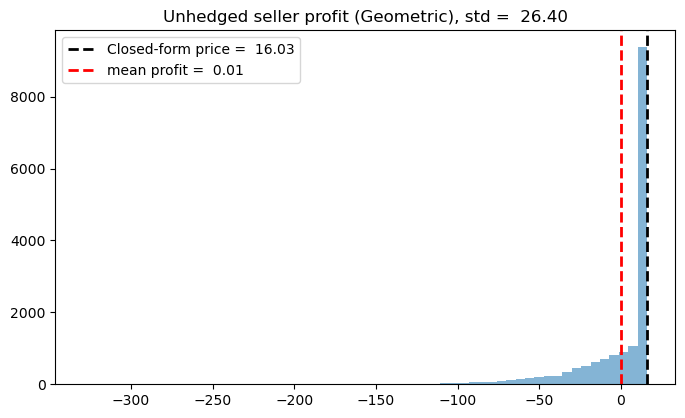

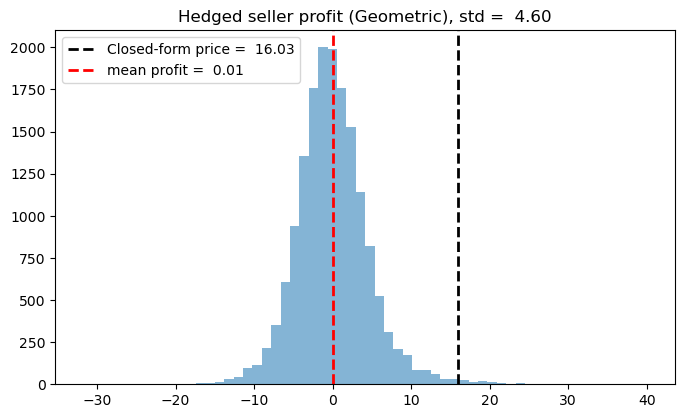

Hedging statistics, Arithmetic (hedged with conditional geometric deltas):
  mean(unhedged) =  0.020526
  mean(  hedged) =  0.016545
  std (unhedged) =  30.053435
  std (  hedged) =  4.243209
  VAR RATIO (hedged/unhedged) =  0.019934

V0 (RQMC) = 18.232038,  Delta0 (Arithmetic, CFD) = 0.609628


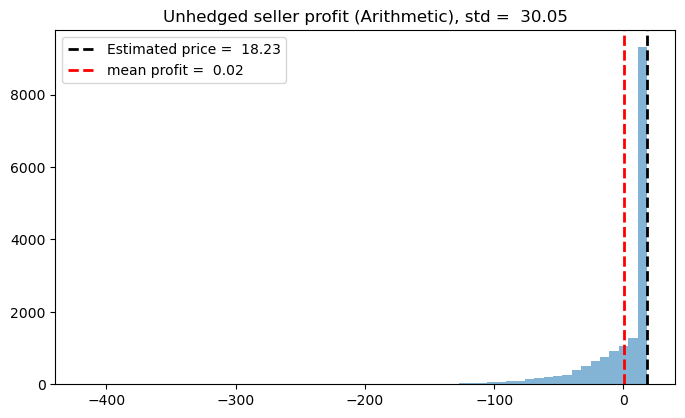

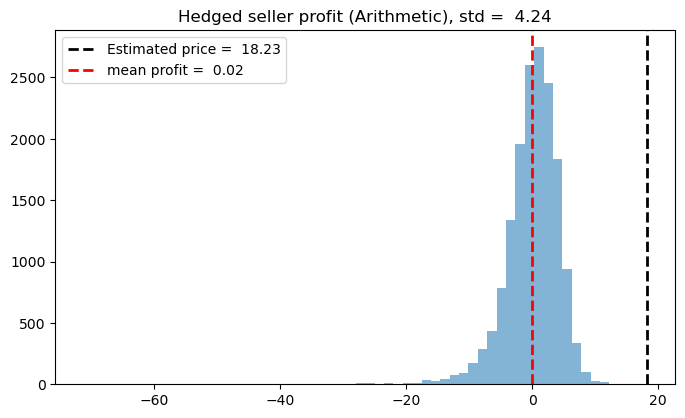

In [8]:
# Price & Δ0 arith
V0_mean, V0_stdR, bstar = price_rqmc_geomcv(n_paths_est, R_repl_est, seed=BASE_SEED+1)
Delta0_mean, Delta0_stdR = delta0_cfd_rqmc_geomcv_FIXED(n_paths_est, R_repl_est, h_rel=h_rel, seed=BASE_SEED+2)

# Price & Δ0 geom
V0_geom = asian.geometric_asian_call_price_discrete(S0=S0, K=K, r=r, sigma=sigma, T=T, d=d)
Delta0_geom = geom_delta_0_closed_form(S0=S0, K=K, r=r, sigma=sigma, T=T, d=d)

# Evaluation paths (RQMC)
base_U = lds.sobol_points(n=n_paths_eval, d=d, scramble=False, seed=BASE_SEED+88)
U_eval = lds.random_digital_shift(base_U, seed=BASE_SEED+99)
Z_eval = lds.u_to_normal(U_eval)
S_eval = build_paths_from_Z(Z_eval, S0, T, d)

# Hedge
pv_unhedged, pv_hedged, pv_unhedged_geom, pv_hedged_geom = hedge_pv_pnl_seller__CONDITIONAL(
    S_eval, V0_mean, Delta0_geom, V0_geom, delta0_override=Delta0_mean
)

# Stats and plots, Geometric
def stats(name, un, hd):
    vr = (hd.std()**2) / (un.std()**2)
    print(name)
    print(f"  mean(unhedged) = {un.mean(): .6f}")
    print(f"  mean(  hedged) = {hd.mean(): .6f}")
    print(f"  std (unhedged) = {un.std(): .6f}")
    print(f"  std (  hedged) = {hd.std(): .6f}")
    print(f"  VAR RATIO (hedged/unhedged) = {vr: .6f}\n")

stats("Hedging statistics, Geometric:", pv_unhedged_geom, pv_hedged_geom)
print(f"V0 (Closed-form) = {V0_geom:.6f},  Delta0 (Closed-form) = {Delta0_geom:.6f}")

plt.figure(figsize=(8,4.6))
plt.axvline(V0_geom, linestyle='--', linewidth=2, label=f'Closed-form price = {V0_geom: .2f}', color='black')
plt.axvline(pv_unhedged_geom.mean(), linestyle='--', linewidth=2, label=f'mean profit = {pv_unhedged_geom.mean(): .2f}', color='red')
plt.hist(pv_unhedged_geom, bins=60, alpha=0.55)
plt.legend(); plt.title(f"Unhedged seller profit (Geometric), std = {pv_unhedged_geom.std(): .2f}"); plt.show()

plt.figure(figsize=(8,4.6))
plt.axvline(V0_geom, linestyle='--', linewidth=2, label= f'Closed-form price = {V0_geom: .2f}', color='black')
plt.axvline(pv_hedged_geom.mean(), linestyle='--', linewidth=2, label= f'mean profit = {pv_hedged_geom.mean(): .2f}', color='red')
plt.hist(pv_hedged_geom,   bins=60, alpha=0.55)
plt.legend(); plt.title(f"Hedged seller profit (Geometric), std = {pv_hedged_geom.std(): .2f}"); plt.show()

# Stats and plots, Arithmetic
stats("Hedging statistics, Arithmetic (hedged with conditional geometric deltas):", pv_unhedged, pv_hedged)
print(f"V0 (RQMC) = {V0_mean:.6f},  Delta0 (Arithmetic, CFD) = {Delta0_mean:.6f}")

plt.figure(figsize=(8,4.6))
plt.axvline(V0_mean, linestyle='--', linewidth=2, label= f'Estimated price = {V0_mean: .2f}', color='black')
plt.axvline(pv_unhedged.mean(), linestyle='--', linewidth=2, label= f'mean profit = {pv_unhedged.mean(): .2f}', color='red')
plt.hist(pv_unhedged, bins=60, alpha=0.55)
plt.legend(); plt.title(f"Unhedged seller profit (Arithmetic), std = {pv_unhedged.std(): .2f}"); plt.show()

plt.figure(figsize=(8,4.6))
plt.axvline(V0_mean, linestyle='--', linewidth=2, label=f'Estimated price = {V0_mean: .2f}', color='black')
plt.axvline(pv_hedged.mean(), linestyle='--', linewidth=2, label= f'mean profit = {pv_hedged.mean(): .2f}', color='red')
plt.hist(pv_hedged,   bins=60, alpha=0.55)
plt.legend(); plt.title(f"Hedged seller profit (Arithmetic), std = {pv_hedged.std(): .2f}"); plt.show()

